In [1]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import polars as pl
import umap
from pipeline import cluster, filter_redundant_factors, find_lowest_common_ancestor
from plotting import plot_columns, plot_rho_curve, save_matrix
from scipy.cluster.hierarchy import (
    ClusterNode,
    dendrogram,
)
from scipy.spatial.distance import pdist, squareform

In [2]:
RUN_HEAVY = False

In [3]:
YOX1 = "YML027W"
YHP1 = "YDR451C"
CLN3 = "YAL040C"

In [4]:
df_data = pl.read_csv("../data/preprocessed_2090_combined_timeseries.csv", null_values=["NA"])
genes = np.array(df_data.columns)

In [5]:
df_ccm = pl.read_csv("../data/Cell_Cycle_5690_CCM_all_vs_all.csv", null_values=["NA"]).drop("")
df_ccm.head()

E,tau,tp,nn,lib_column,target_column,lib_size,num_pred,rho,mae,rmse
i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64
4,3,0,5,1,1,99,99,0.939771,2.248597,3.228245
4,3,0,5,1,2,99,99,0.939771,2.248597,3.228245
4,3,0,5,1,3,99,99,0.171424,0.784599,1.19442
4,3,0,5,1,4,99,99,-0.003084,0.443868,0.572092
4,3,0,5,1,5,99,99,-0.119612,11.651889,32.504013


In [6]:
if RUN_HEAVY:
    df_ccm.describe()

In [7]:
best_rho = df_ccm.group_by(["lib_column", "target_column"]).agg(pl.max("rho")).sort("lib_column", "target_column")
best_rho

lib_column,target_column,rho
i64,i64,f64
1,1,0.939771
1,2,0.939771
1,3,0.171424
1,4,-0.003084
1,5,-0.119612
…,…,…
5690,5686,0.146628
5690,5687,0.058904
5690,5688,-0.00829


In [8]:
N = len(df_ccm.unique(subset="lib_column"))
ccm = best_rho["rho"].to_numpy().reshape((N, N))

N_nan = np.isnan(ccm).sum().sum()
print(f"Number of NaNs: {N_nan}", f"Percentage of NaNs: {N_nan / (N * N) * 100}%")

Number of NaNs: 0 Percentage of NaNs: 0.0%


In [9]:
ccm_clustered, Z_ccm = cluster(ccm, method="average")

if RUN_HEAVY:
    save_matrix(ccm, "../outputs/CCM.png")
    save_matrix(ccm_clustered, "../outputs/CCM_clusterd.png")

In [10]:
corr = df_data.corr().to_numpy()

In [11]:
corr_clustered, Z_corr = cluster(corr, method="average")

if RUN_HEAVY:
    save_matrix(corr, "../outputs/correlation.png")
    save_matrix(corr_clustered, "../outputs/correlation_clustered.png")

In [12]:
rhodiff = ccm - corr

In [13]:
rhodiff_clustered, Z_rhodiff = cluster(rhodiff, method="average")

if RUN_HEAVY:
    save_matrix(rhodiff, "../outputs/rhodiff.png")
    save_matrix(rhodiff_clustered, "../outputs/rhodiff_clustered.png")

In [14]:
target_gene_indecies = np.array(
    [
        np.argwhere(genes == YOX1).squeeze(),
        np.argwhere(genes == YHP1).squeeze(),
        np.argwhere(genes == CLN3).squeeze(),
    ]
)
print(target_gene_indecies)

[3924 1310   66]


In [15]:
def create_link_color_func(
    target_gene_indecies: np.ndarray,
    lca: ClusterNode,
    paths: dict[int, list[int]],
    leaves: np.ndarray,
):
    target_nodes = set()
    subtree_nodes = set()

    for leaf in leaves:
        path = np.array(paths[leaf])
        if leaf in target_gene_indecies:
            target_nodes.add(path[-1])
        subtree_nodes.update(path[path < lca.id])

    subtree_nodes.add(lca.id)

    def link_color_func(i):
        if i in target_nodes:
            return "blue"
        if i in subtree_nodes:
            return "red"
        return "gray"

    return link_color_func


def create_leaf_label_func(target_gene_indecies: np.ndarray):
    def leaf_label_func(i):
        if i in target_gene_indecies:
            return genes[i]
        return None

    return leaf_label_func


if RUN_HEAVY:
    for Z, src in [(Z_ccm, "CCM"), (Z_rhodiff, "rhodiff")]:
        for i, by in [(0, "upstream"), (1, "downstream")]:
            lca, paths, leaves = find_lowest_common_ancestor(
                Z[i],
                target_gene_indecies,
            )
            dn = dendrogram(
                Z[i],
                # no_labels=True,
                link_color_func=create_link_color_func(target_gene_indecies, lca, paths, leaves),
                leaf_label_func=create_leaf_label_func(target_gene_indecies),
                leaf_rotation=90,
                leaf_font_size=8,
            )
            plt.title(f"{src} clusterd by {by}")
            plt.tight_layout()
            plt.savefig(f"../outputs/dendrogram_{src}_{by}.png", dpi=300)
            plt.clf()

In [16]:
lca, paths, leaves = find_lowest_common_ancestor(
    Z_ccm[0],
    target_gene_indecies,
)

In [17]:
ccm_extracted_cluster = ccm[leaves][:, leaves]
ccm_extracted_cluster.shape

(1146, 1146)

In [18]:
filtered_corr, redundancy_mask = filter_redundant_factors(corr, 0.9)
redundant_factors = np.where(~redundancy_mask)[0]
print(len(filtered_corr), len(redundant_factors), redundant_factors)

Filtering redundant factors: 100%|██████████| 5690/5690 [00:00<00:00, 20418.45it/s]


4389 1301 [   1    5    6 ... 5680 5682 5683]


In [19]:
ccm_filtered_redundancy = ccm[redundancy_mask][:, redundancy_mask]
ccm_filtered_redundancy.shape

(4389, 4389)

In [20]:
genes_filtered_redundancy = genes[redundancy_mask]

In [21]:
plot_rho_curve(ccm_filtered_redundancy.flatten())

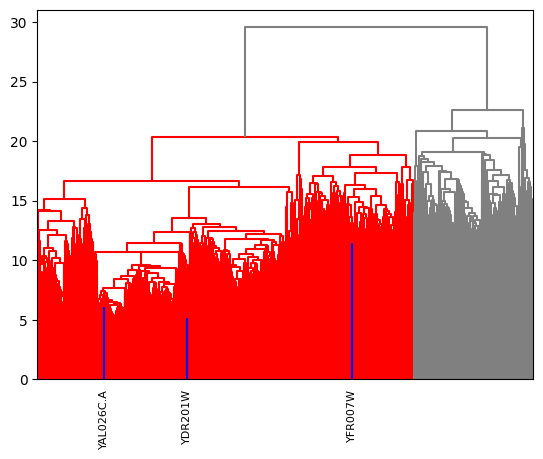

In [22]:
YOX1_Similar = genes[corr[np.argwhere(genes == YOX1).squeeze()] > 0.9]
YOX1_Alternative = YOX1_Similar[np.isin(YOX1_Similar, genes_filtered_redundancy)][0]

target_gene_indecies = np.array(
    [
        np.argwhere(genes_filtered_redundancy == YOX1_Alternative).squeeze(),
        np.argwhere(genes_filtered_redundancy == YHP1).squeeze(),
        np.argwhere(genes_filtered_redundancy == CLN3).squeeze(),
    ]
)

ccm_filtered_redundancy_clustered, Z_ccm_filtered_redundancy = cluster(ccm_filtered_redundancy, method="average")

lca, paths, leaves = find_lowest_common_ancestor(Z_ccm_filtered_redundancy[0], target_gene_indecies)

dn = dendrogram(
    Z_ccm_filtered_redundancy[0],
    # no_labels=True,
    link_color_func=create_link_color_func(target_gene_indecies, lca, paths, leaves),
    leaf_label_func=create_leaf_label_func(target_gene_indecies),
    leaf_rotation=90,
    leaf_font_size=8,
)

In [23]:
ccm_filtered_redundancy_extracted_cluster = ccm_filtered_redundancy[leaves][:, leaves]
ccm_filtered_redundancy_extracted_cluster.shape
# TODO: plot rho curve with other factors

(3336, 3336)

In [24]:
genes_filtered_redundancy_extracted_cluster = genes_filtered_redundancy[leaves]

In [25]:
plot_rho_curve(ccm_filtered_redundancy_extracted_cluster.flatten())

In [26]:
plot_rho_curve(ccm_filtered_redundancy[np.argwhere(genes_filtered_redundancy == CLN3).squeeze()])

In [27]:
plot_rho_curve(
    ccm_filtered_redundancy_extracted_cluster[
        np.argwhere(genes_filtered_redundancy_extracted_cluster == CLN3).squeeze()
    ]
)

In [28]:
pathway = genes_filtered_redundancy_extracted_cluster[
    np.argsort(
        ccm_filtered_redundancy_extracted_cluster[
            np.argwhere(genes_filtered_redundancy_extracted_cluster == CLN3).squeeze()
        ]
    )
]
pathway, YOX1, YHP1, CLN3

(array(['YPR170W.B', 'YDR068W', 'YGR206W', ..., 'YGR279C', 'YLR274W',
        'YGL021W'], dtype='<U9'),
 'YML027W',
 'YDR451C',
 'YAL040C')

In [29]:
np.argwhere(np.isin(pathway, [YOX1_Alternative, YHP1, CLN3]))

array([[1825],
       [3279],
       [3313]])

In [30]:
fit = umap.UMAP()
embedding_of_ccm_filtered_redundancy: np.ndarray = fit.fit_transform(  # type: ignore
    ccm_filtered_redundancy
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [31]:
layout = go.Layout(
    title="UMAP of CCM genes",
    xaxis=dict(title="UMAP1"),
    yaxis=dict(title="UMAP2"),
    width=800,
    height=800,
)

data = [
    go.Scatter(
        x=embedding_of_ccm_filtered_redundancy[:, 0],
        y=embedding_of_ccm_filtered_redundancy[:, 1],
        mode="markers",
        marker=dict(
            color=["red" if gene in [YOX1_Alternative, YHP1, CLN3] else "blue" for gene in genes_filtered_redundancy],
            size=[8 if gene in [YOX1_Alternative, YHP1, CLN3] else 5 for gene in genes_filtered_redundancy],
        ),
        text=genes_filtered_redundancy,
        hoverinfo="text",
    )
]

fig = go.Figure(data=data, layout=layout)
fig.show()

In [32]:
plot_columns(df_data, YOX1_Similar)  # type: ignore

In [33]:
fit = umap.UMAP()
embedding_of_ccm: np.ndarray = fit.fit_transform(ccm)  # type: ignore

In [34]:
layout = go.Layout(
    title="UMAP of CCM genes",
    xaxis=dict(title="UMAP1"),
    yaxis=dict(title="UMAP2"),
    width=800,
    height=800,
)

data = [
    go.Scatter(
        x=embedding_of_ccm[:, 0],
        y=embedding_of_ccm[:, 1],
        mode="markers",
        marker=dict(
            color=["red" if gene in [YOX1, YHP1, CLN3] else "blue" for gene in genes],
            size=[8 if gene in [YOX1, YHP1, CLN3] else 5 for gene in genes],
        ),
        text=genes,
        hoverinfo="text",
    )
]

fig = go.Figure(data=data, layout=layout)
fig.show()

In [35]:
upstream_similarity = np.corrcoef(ccm)
np.isin(
    [YOX1, YHP1],
    genes[np.argsort(upstream_similarity[np.argwhere(genes == CLN3).squeeze()])][-100:],
)

array([False, False])

In [36]:
center = embedding_of_ccm[np.argwhere(genes == CLN3).squeeze()]
mask = squareform(pdist(embedding_of_ccm - center))[np.argwhere(genes == CLN3).squeeze()] < 0.8

genes_extracted_umap_cluster = genes[mask]

In [37]:
layout = go.Layout(
    title="UMAP of CCM genes",
    xaxis=dict(title="UMAP1"),
    yaxis=dict(title="UMAP2"),
    width=800,
    height=800,
)

data = [
    go.Scatter(
        x=embedding_of_ccm[:, 0],
        y=embedding_of_ccm[:, 1],
        mode="markers",
        marker=dict(
            color=[
                "green" if gene in [YOX1, YHP1, CLN3] else "red" if gene in genes_extracted_umap_cluster else "blue"
                for gene in genes
            ],
            size=[8 if gene in genes_extracted_umap_cluster else 5 for gene in genes],
        ),
        text=genes,
        hoverinfo="text",
    )
]

fig = go.Figure(data=data, layout=layout)
fig.show()

In [38]:
filtered_corr_extracted_umap_cluster, redundancy_mask_extracted_umap_cluster = filter_redundant_factors(
    corr[mask][:, mask], 0.9
)

Filtering redundant factors: 100%|██████████| 147/147 [00:00<00:00, 165121.23it/s]


In [39]:
layout = go.Layout(
    title="UMAP of CCM genes",
    xaxis=dict(title="UMAP1"),
    yaxis=dict(title="UMAP2"),
    width=800,
    height=800,
)

data = [
    go.Scatter(
        x=embedding_of_ccm[:, 0],
        y=embedding_of_ccm[:, 1],
        mode="markers",
        marker=dict(
            color=[
                # "green"
                # if gene in [YOX1, YHP1, CLN3]
                # else "red"
                "red" if gene in genes_extracted_umap_cluster[redundancy_mask_extracted_umap_cluster] else "blue"
                for gene in genes
            ],
            size=[8 if gene in genes_extracted_umap_cluster else 5 for gene in genes],
        ),
        text=genes,
        hoverinfo="text",
    )
]

fig = go.Figure(data=data, layout=layout)
fig.show()